In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = r"F:/modal1/"


In [3]:
# Hair removal function
def remove_hair(image_path): 
    """Remove hair from the image without blurring."""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Invalid image path or format.")

        original_image = image.copy()  # Keep the original image for comparison

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect hair using morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

        # Threshold the blackhat image to create a mask for hair regions
        _, hair_mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

        # Inpaint the detected hair regions with minimal blur
        inpainted_image = cv2.inpaint(image, hair_mask, inpaintRadius=3, flags=cv2.INPAINT_NS)  # Use Navier-Stokes inpainting

        # Compare if the processed image is different from the original image
        if np.array_equal(original_image, inpainted_image):
            return None  # No change, return None to indicate no modification

        # Return the modified image directly without saving
        return inpainted_image  # Return the inpainted image directly
    except Exception as e:
        print(f"Error during hair removal: {e}")
        raise

In [4]:
# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

In [5]:
def preprocess_image(image_path):
    """Preprocess the image by removing hair and resizing."""
    # Remove hair from the image
    image = remove_hair(image_path)
    if image is not None:
        image = cv2.resize(image, IMG_SIZE)  # Resize the image to match IMG_SIZE
        return image
    return None

In [6]:

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification (normal vs. abnormal)
    subset='training'
)

Found 1041 images belonging to 2 classes.


In [7]:
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 259 images belonging to 2 classes.


In [8]:
# Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [9]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/20
33/33 [==============================] - 139s 4s/step - loss: 0.2802 - accuracy: 0.8924 - val_loss: 0.3523 - val_accuracy: 0.9073
Epoch 2/20
33/33 [==============================] - 104s 3s/step - loss: 0.1725 - accuracy: 0.9251 - val_loss: 0.1629 - val_accuracy: 0.9498
Epoch 3/20
33/33 [==============================] - 70s 2s/step - loss: 0.1296 - accuracy: 0.9500 - val_loss: 0.0758 - val_accuracy: 0.9730
Epoch 4/20
33/33 [==============================] - 48s 1s/step - loss: 0.0974 - accuracy: 0.9645 - val_loss: 0.0720 - val_accuracy: 0.9730
Epoch 5/20
33/33 [==============================] - 37s 1s/step - loss: 0.0752 - accuracy: 0.9635 - val_loss: 0.0675 - val_accuracy: 0.9614
Epoch 6/20
33/33 [==============================] - 40s 1s/step - loss: 0.0710 - accuracy: 0.9721 - val_loss: 0.0391 - val_accuracy: 0.9807
Epoch 7/20
33/33 [==============================] - 40s 1s/step - loss: 0.0309 - accuracy: 0.9923 - val_loss: 0.0423 - val_accuracy: 0.9807
Epoch 8/20
33/33 [

In [10]:

# Save the model
model.save('skin_cancer_or_not_model.h5')


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


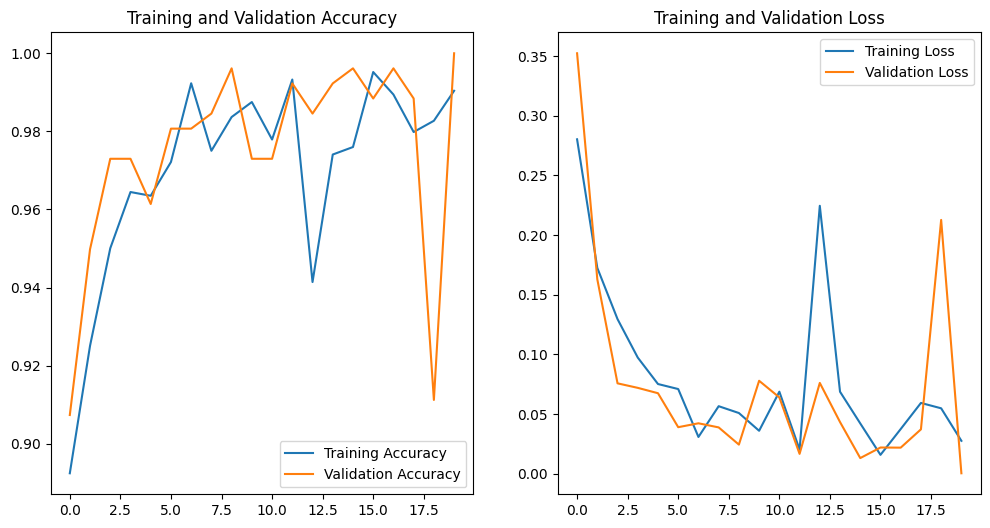

In [11]:
# Plot Training Results
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training(history)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('skin_cancer_or_not_model.h5')  # Path to your saved model

# Function to preprocess and predict an image
def predict_image(img_path):
    IMG_SIZE = (128, 128)  # Same as used during training
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (rescale)
    
    # Make a prediction
    prediction = model.predict(img_array)
    
    # Output result
    if prediction[0] > 0.5:
        print(f"The image is classified as: **Cancerous Skin** (Abnormal) with confidence {prediction[0]}")
    else:
        print(f"The image is classified as: **Normal Skin** with confidence {1 - prediction[0]}")

# Test the function with an example image path
test_image_path = r'F:\modal1\normal\sdcvzx.jpg'  # Replace with your test image path
predict_image(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
The image is classified as: **Cancerous Skin** (Abnormal) with confidence [0.9410702]


In [13]:
print(model.input_shape)


(None, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (300, 300)  # Set to 300x300 for best accuracy
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = r"F:/modal1/"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load Pretrained EfficientNetB3
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Fine-tune the model: Unfreeze some layers of EfficientNetB3
base_model.trainable = True
fine_tune_at = 200  # Unfreeze from layer 200 onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Model Definition
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# Save Model
model.save('efficientnetb3_skin_cancer_model.h5')

# Plot training results
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training(history)


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/20


In [3]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model("efficientnetb3_skin_cancer_model.h5")

# Function to preprocess an image
def preprocess_image(img_path, img_size=(300, 300)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize
    return img_array, np.array(img)

# Function to compute Grad-CAM
def compute_gradcam(img_path, model, last_conv_layer_name="top_conv"):
    img_array, original_img = preprocess_image(img_path)

    # Get model output and gradient with respect to last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = predictions[0][0]  # Binary classification

        # Compute gradients
        grads = tape.gradient(predictions, conv_outputs)

    # Compute importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Compute heatmap
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap, original_img, predicted_class

# Function to overlay Grad-CAM heatmap on the original image
def overlay_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(heatmap, alpha, np.array(original_img), 1 - alpha, 0)
    return superimposed_img

# Path to an image for visualization
img_path = "path_to_test_image.jpg"  # Replace with your image path

# Compute Grad-CAM
heatmap, original_img, predicted_class = compute_gradcam(img_path, model)

# Overlay the heatmap
gradcam_image = overlay_heatmap(heatmap, original_img)

# Display results
plt.figure(figsize=(12, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.axis("off")
plt.title("Original Image")

# Grad-CAM Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap="jet")
plt.axis("off")
plt.title("Grad-CAM Heatmap")

# Overlayed Image
plt.subplot(1, 3, 3)
plt.imshow(gradcam_image)
plt.axis("off")
plt.title(f"Grad-CAM Overlay (Prediction: {predicted_class:.2f})")

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_test_image.jpg'

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model
model = tf.keras.models.load_model('efficientnetb3_skin_cancer_model.h5')  # Path to your saved model

def predict_image(img_path):
    IMG_SIZE = (300, 300)  # Same size as used during training
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image

    # Make a prediction
    prediction = model.predict(img_array)

    # Show raw prediction output
    print(f"Raw Prediction Output: {prediction[0][0]}")  # Output between 0 and 1

    # Adjust threshold here (e.g., use 0.6)
    threshold = 0.6
    if prediction[0][0] < threshold:
        print(f"The image is classified as: **Cancerous Skin** (Abnormal) with confidence {1 - prediction[0][0]:.2f}")
    else:
        print(f"The image is classified as: **Normal Skin** with confidence {prediction[0][0]:.2f}")

# Test the function with an example image path
test_image_path = r'F:\modal1\normal\photo_3_2023-06-24_12-13-13.jpg'  # Replace with your test image path
predict_image(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Raw Prediction Output: 0.09928282350301743
The image is classified as: **Cancerous Skin** (Abnormal) with confidence 0.90
